<a href="https://colab.research.google.com/github/Muhammad0Awais/Intro_to_AI/blob/main/intro_to_AI/Labs/genetic_path_planner_passed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic path planning
* This time we will be taking a look at slightly different application for genetic algorithms.
Turns out that GAs can be used to solve a problem of path-planning, a key part of navigation systems in robotics


* Your task will be to complete this code below with mutation, crossover and fitness evaluation functions

First off, some imports and convenience classes 

In [ ]:
from __future__ import annotations
from abc import ABC  #  abstract base classes https://docs.python.org/3/library/abc.html
from itertools import product
from time import sleep
import math
import numpy as np
from numpy.typing import NDArray
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString
from descartes import PolygonPatch
import random
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

Creating a class for points that inherits the Point class in [shapely.geometry](https://shapely.readthedocs.io/en/stable/manual.html). This class

In [ ]:
class MyPoint(Point):
    def __init__(self, *args):
        super().__init__(*args)

    def __add__(self, other):
        return MyPoint(self.x + other.x, self.y + other.y)

    def scale(self, ratio):

        return MyPoint(self.x * ratio, self.y * ratio)

    def get_xy(self):
        return self.x, self.y

    def rotate(self, theta):
        c, s = np.cos(theta), np.sin(theta)
        r = np.array([[c, -s], [s, c]])
        new_xy = list(np.matmul(r, self.get_xy()))
        return MyPoint(new_xy[0], new_xy[1])

In [ ]:
class MyLineString(LineString):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def bearing(self):
        return math.atan2(self.coords[1][1] - self.coords[0][1],
                          self.coords[1][0] - self.coords[0][0])

    def get_angle(self, other):
        return math.fabs(self.bearing() - other.bearing()) % math.pi

In [ ]:
class Obstacle(Polygon, ABC):

    def __init__(self, center_point, size=1.):
        self.center = center_point
        corners = [MyPoint(-1, -1), MyPoint(-1, 1), MyPoint(1, 1),
                   MyPoint(1, -1)]
        corners = [p.scale(size) for p in corners]
        new_corners = [c + center_point for c in corners]
        self.p = Polygon([(p.x, p.y) for p in new_corners])
        super().__init__(self.p)

    def get_drawable(self, color):
        return PolygonPatch(self.p, color=color)

    def get_center(self):
        return self.center

In [ ]:
from typing import List, Tuple


class Robot:
    _points: List[Point]
    lines: List[MyLineString]
    def __init__(self, start_point, end_point, grid_num, obstacles):
        self.start: MyPoint = start_point
        self.stop: MyPoint = end_point
        self._point_num: int = grid_num
        self.obstacles: List[Obstacle] = obstacles
        self._create_st_line()

    def _create_st_line(self):
        # Line that connects start and stop points
        self.st_line = MyLineString(
            [self.start.get_xy(), self.stop.get_xy()])
        self.theta = math.atan2(self.stop.y - self.start.y,
                                self.stop.x - self.start.x)
        self.__x_prime_array = np.arange(
            0, self.st_line.length + self.st_line.length / self._point_num,
            self.st_line.length / self._point_num)

        self._points = [MyPoint(x, 0) for x in self.__x_prime_array]
        self.lines = []

    def set_start_stop_point(self, s_point, t_point):
        self.start = s_point
        self.stop = t_point
        self._create_st_line()

    def update_points(self, points):
        points = [0] + points + [0]
        self._points = [
            MyPoint(x, y).rotate(self.theta) for x, y in zip(self.__x_prime_array, points)]
        self._points = [
            MyPoint(p.x, p.y) + self.start for p in self._points]
        self.lines = [
            MyLineString([p1.get_xy(), p2.get_xy()]) for
            p1, p2 in zip([self.start] + self._points, self._points + [self.stop])]

    def get_cost(self, points=None) -> float:
        if points is None:
            points = []
        if len(points) != 0:
            self.update_points(points)

        # TODO
        # calculate total cost of this path

        # hint: you can choose different coefficients for different parts of cost function
        pass

    def get_intersection_penalty(self) -> float:
        # TODO
        # write code that penalises path for intersection with obstacles

        # hint: lines and obstacles attributes will be populated with needed data
        pass
    def get_length_penalty(self) -> float:
        # TODO
        # long paths are bad because of energy efficiency concerns. Penalise them
        pass

    def get_angle_penalty(self) -> float:
        # TODO
        # sharp turns are also vad
        pass

    def get_clearance_penalty(self) -> float:
        # TODO
        # It is bad to have paths nearby the obstacles because there is always some degree of uncertainty in robot movement
        # This uncertainty might be great enough to cause a collision if the path lies nearby the obstacle.
        pass

    def get_path(self):
        return LineString([p.get_xy() for p in self._points])

In [ ]:
class Chromosome:
    genes: NDArray
    def __init__(self, genes_len=10, gene_pool_min=-5, gene_pool_max=5, genes=None):
        if genes is None:
            self.genes = np.random.uniform(gene_pool_min, gene_pool_max, genes_len)
        else:
            self.genes = genes

    def mutate(self, gene_pool_min: int, gene_pool_max: int) -> Chromosome:
        # TODO
        # mutate chromosome, return a new one
        # hint: you can create a new chromosome from a gene array
        pass

    def crossover(self, other: Chromosome) -> Tuple[Chromosome, Chromosome]:
        # TODO
        # perform crossover between this and other chromosome
        pass

    def get_genes(self):
        return list(self.genes).copy()

In [ ]:
class GA:
    # get size of population and chromosome and talent size at the first
    def __init__(self, chr_size, talent_size):
        self._chr_size = chr_size
        self._talentSize = talent_size
        self.population = []
        self.top = {"cost_value": float('Inf'), "chr": []}

    def reset_top(self):
        self.top = {"cost_value": float('Inf'), "chr": []}

    def reset(self, pop_size):
        self.population = []
        self.gen_population(gene_pool_min=-3, gene_pool_max=3, pop_size=pop_size)

    def append_population(self, population):
        self.population = self.population + population

    def change_population(self, pop):
        del (self.population[int(len(self.population) / 2):])
        self.append_population(pop)

    def gen_population(self, gene_pool_max, gene_pool_min, pop_size):
        for p in range(pop_size):
            self.population.append(
                Chromosome(self._chr_size, gene_pool_min, gene_pool_max))
        return self.population

    def mutation(self, num, gene_pool_min, gene_pool_max):
        if num > len(self.population):
            raise ValueError("number of mutation is higher than population")
        mutated = []
        mutate_indexes = np.random.randint(0, len(self.population), num)
        for mutate_index in mutate_indexes:
            mutated = mutated + [
                self.population[mutate_index].mutate(gene_pool_min, gene_pool_max)]
        return mutated

    def crossover(self, num):
        crossover_pop = []
        for i in range(num):
            s = list(np.random.randint(0, len(self.population), 2))
            crossover_pop = crossover_pop + self.population[s[0]].crossover(
                self.population[s[1]])
        return crossover_pop

    def calc_fitness(self, func, pop=None):
        if pop is None:
            pop = []
        if len(pop) == 0:
            fitness_list = [func(chr_.get_genes()) for chr_ in self.population]
        else:
            fitness_list = [func(chr_.get_genes()) for chr_ in pop]
        sorted_list = sorted(zip(fitness_list, self.population),
                             key=lambda f: f[0])
        # print("chromosome with fitness =",[(a[0], a[1].getGenes()) for a in sorted_list])
        sorted_chromosome = [s[1] for s in sorted_list]
        top_fitness = sorted_list[0][0]
        if self.top["cost_value"] > top_fitness:
            self.top["cost_value"] = top_fitness
            self.top["chr_"] = sorted_list[0][1]
        return sorted_chromosome, top_fitness

Now we will set up main GA loop, and iterate through it's elements

In [ ]:
# create robot object
run_index = 1
flag = True
grid_size = 15
pop_size = 20
r = Robot(MyPoint(0, 0), MyPoint(10, 10), grid_size + 1, None)
ga = GA(chr_size=grid_size, talent_size=3)
g = ga.gen_population(gene_pool_min=-5, gene_pool_max=5, pop_size=pop_size)


def ga_iterate(num, mutate_chance=0.8, mutate_min=-15, mutate_max=15):
    global flag
    cost = []
    for i in range(num):
        best_path, most_fit = ga.calc_fitness(r.get_cost)
        cost.append(most_fit)
        ga.population = best_path
        crossovered = ga.crossover(int(pop_size / 2))
        # best_crossovered_path = ga.calPopFitness(r.getFitness, pop=crossovered)
        # print("len ga", len(ga.getPopulation()))
        if flag:
            ga.append_population(crossovered)
            flag = False
        else:
            ga.change_population(crossovered)

        a = np.random.uniform(0, 1, 1)
        if a < mutate_chance:
            mutated = ga.mutation(pop_size, mutate_min, mutate_max)
            ga.change_population(mutated)
    return best_path, cost

When everything completed, you can play around with number of iterations and runs, with penalisation coefficients
That's fun, just plug new values and see what happens

In [ ]:
ITERATION_NUMBER = 10
RUN_NUMBER = 5

START = (1, 1)
END = (10, 10)

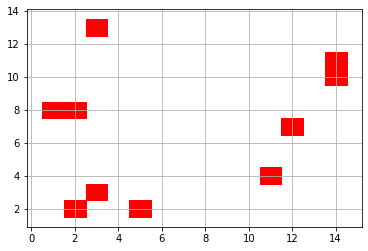

Fit: 130.01299827280553
Length penalty:27.781285695291
Angle penalty:2.356832226003553
Clearance penalty:0.9193577237444958
Intersection penalty:0
Fit: 130.01299827280553
Length penalty:27.781285695291
Angle penalty:2.356832226003553
Clearance penalty:0.9193577237444958
Intersection penalty:0
Fit: 130.01299827280553
Length penalty:27.781285695291
Angle penalty:2.356832226003553
Clearance penalty:0.9193577237444958
Intersection penalty:0
Fit: 117.18341797298118
Length penalty:24.31932831646969
Angle penalty:2.1531898790568498
Clearance penalty:0.9193577237444958
Intersection penalty:0
Fit: 108.88084118683278
Length penalty:21.740553804666295
Angle penalty:2.0082732134805075
Clearance penalty:0.9779950605533904
Intersection penalty:0


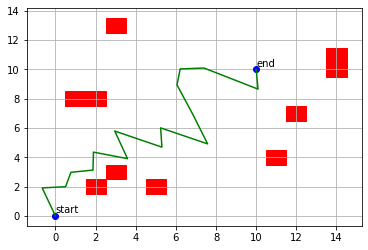

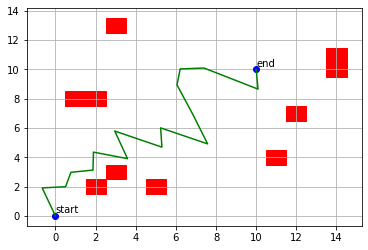

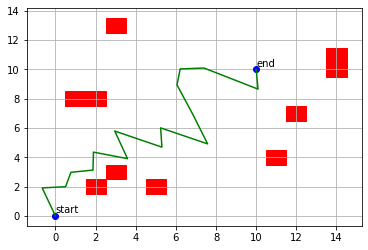

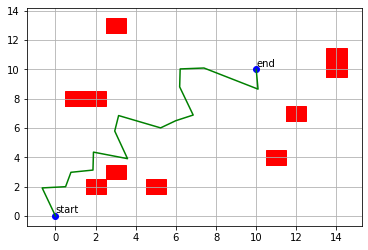

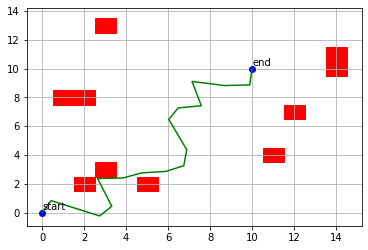

In [ ]:
def run():
    for _ in range(RUN_NUMBER):
        fig, ax = plt.subplots()
        ax.clear()
        best_path, score = ga_iterate(num=ITERATION_NUMBER)
        r.update_points(list(best_path[0].get_genes()))
        p = r.get_path()

        ax.grid(b=None, which='both', axis='both')
        draw_start_stop_points(ax, r.start, r.stop)
        draw_obstacles(ax, r.obstacles)
        ax.autoscale(enable=True, axis='both', tight=None)

        draw_path(ax, p)
        print("Fit:", r.get_cost())
        print("Length penalty:{}".format(r.get_length_penalty()))
        print("Angle penalty:{}".format(r.get_angle_penalty()))
        print("Clearance penalty:{}".format(r.get_clearance_penalty()))
        print("Intersection penalty:{}".format(r.get_intersection_penalty()))
        plt.show()

# some function for better viewing
def draw_start_stop_points(ax, start, end):
    ax.plot([start.x], [start.y], 'ro', color="blue"),
    ax.annotate("start", xy=(start.x, start.y),
                xytext=(start.x, start.y + 0.2))
    ax.plot([end.x], [end.y], 'ro', color="blue")
    ax.annotate("end", xy=(end.x, end.y),
                xytext=(end.x, end.y + 0.2))


def draw_obstacles(ax, obstacles, color="red"):
    for obs in obstacles:
        ax.add_patch(obs.get_drawable(color))


def draw_path(ax, p):
    ax.add_line(
        mlines.Line2D([p.coords[i][0] for i in range(len(p.coords))],
                      [p.coords[i][1] for i in range(len(p.coords))],
                      color="green"))


def reset_obstacle(ax):
    global pop_size
    ga.reset_top()
    ga.reset(pop_size)
    ax.clear()
    ax.grid(b=None, which='both', axis='both')
    obstacles = [
        Obstacle(MyPoint(random.randint(1, 15), random.randint(1, 15)), 0.5)
        for i in range(10)]
    r.obstacles = obstacles
    draw_obstacles(ax, obstacles)
    ax.autoscale(enable=True, axis='both', tight=None)


fig, axis = plt.subplots()
reset_obstacle(axis)
plt.show()
run()


